#### Link to dataset utilized: https://www.consumerfinance.gov/data-research/consumer-complaints/
#### add data folder to .gitignore

# How can we build complaint analytics to help determine what matters to our customers?

In [44]:
import string
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import re
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

def dateLookup(s):
    """
    Memoization solution for faster date_time parsing
    source: https://stackoverflow.com/questions/29882573/pandas-slow-date-conversion
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

def remove_redact(text):
    return re.sub('XX/?','',text)

def bow_vectorize(text_series,max_df):
    cv = CountVectorizer(stop_words='english',min_df=0.0001,max_df=max_df,ngram_range=(1,6), max_features = 15000)
    m = cv.fit_transform(text_series)
    return {'cv':cv,'m':m}

def bow_conform(text_series,feature_names):
    cv = CountVectorizer(stop_words='english',ngram_range=(1,6), max_features = 15000, vocabulary = feature_names)
    m = cv.fit_transform(text_series)
    return {'cv':cv,'m':m}

def tfidf_vectorize(bow_m,sublinear_tf):
    tt = TfidfTransformer(norm='l2',smooth_idf=True,use_idf=True,sublinear_tf=sublinear_tf)
    m = tt.fit_transform(bow_m)
    return {'tt':tt,'m':m}


In [3]:
c = pd.read_csv('Consumer_Complaints.csv')

#Take subset where complaint text is available
c = c[c['Consumer consent provided?'] == 'Consent provided']

#Convert yes/no strings to bool
for col in ['Consumer disputed?','Timely response?']:
    c[col] = (c[col] == 'Yes')
    
#Convert datetimes    
for col in ['Date received', 'Date sent to company']:
    c[col] = dateLookup(c[col])
    
#All complaints in our subset are submitted via web and have consent provided.
c = c.drop(['Consumer consent provided?','Submitted via'],axis='columns')

#Convert all others, convert yes/no bools to int64
dataTypes = {
    'Product':'category',
    'Sub-product':'category',
    'Issue':'category',
    'Sub-issue':'category',
    'Consumer complaint narrative':str,
    'Company public response':str,
    'Company':'category',
    'State':'category',
    'ZIP code':str,
    'Tags':str,
    'Company response to consumer':'category',
    'Timely response?':'int64',
    'Consumer disputed?':'int64',
    'Complaint ID':'int64'
}

c = c.astype(dataTypes)

columnNames = {
    'Date received':'date_received',
    'Product':'product',
    'Sub-product':'sub_product',
    'Issue':'issue',
    'Sub-issue':'sub_issue',
    'Consumer complaint narrative':'text',
    'Company public response':'pub_reply',
    'Company':'company',
    'State':'state',
    'ZIP code':'zip_code',
    'Tags':'tags',
    'Date sent to company':'date_sent',
    'Company response to consumer':'cust_reply',
    'Timely response?':'timely_reply',
    'Consumer disputed?':'disputed',
    'Complaint ID':'ID'
}

c = c.rename(columns = columnNames)

b = c[c['product'] == 'Bank account or service'].copy()

#There are a few missing state entries, and not every complaint has a sub-product or sub-issue.

#Cleaning Up for Word Vectorization.
#Remove XXXXs
#Are numbers significant/helpful? Is there another format that might make them moreso?
#Strings of XXXX are used for redaction. These will need to be removed.

b.loc[:,'clean_text'] = b['text'].apply(remove_redact)

issueAliases = {
    'Account opening, closing, or management':'Account',
    'Deposits and withdrawals':'Transactions',
    'Making/receiving payments, sending money':'Payments',
    'Problems caused by my funds being low':'Low Funds',
    'Using a debit or ATM card':'Card'
}

b['issue'] = b['issue'].map(issueAliases).copy()

issues = sorted(list(issueAliases.values()))

#Set the random seed
np.random.seed(42)

# Sentiment Scoring

1. function takes in a document and returns pos,neg,neutral matches
2. wrapper function computes metrics based on the raw counts
3. wrapper of wrappers compare various metrics.

In [27]:
neg_words = pd.read_csv('data/opinion_lexicon_English/negative-words.txt',sep=' ',
                        skiprows=33,header=None,encoding='latin 1').values
pos_words = pd.read_csv('data/opinion_lexicon_English/positive-words.txt',sep=' ',
                        skiprows=33,header=None,encoding='latin 1').values


#### note that there are 2007 pos words and 4783 neg words. Is the inherent probability of occurence for either set balanced? (does language have a global bias on average?)  read original author's thoughts on this/email if not available.
### How to determine if comparison between categories is believable?
#### Try building in time-discounting function.
### what does the distribution of each metric look like? (normal-ish so far)

#### break up functions so that computing raw pos/neg/neut vectors is seperate from computing metrics (speed up run time)

In [215]:
np.random.seed(42)
issue_sample_size = 800;
issue_text_samples = {i:b[b['issue'] == i].sample(issue_sample_size)['clean_text']. \
                      reset_index(drop=True) for i in issues}

In [232]:
'''
current metric: (neg-pos)/(1+np.log(neutral))
{'Account': 0.1420303441945025,
 'Card': 0.47845196278745583,
 'Low Funds': 0.1955292797192287,
 'Payments': 0.37187204271891994,
 'Transactions': 0.25805231924484201}
'''

def mean_raw_polarity(s_matrix):
    polarity_vec = s_matrix[:,0]-s_matrix[:,2]
    return np.mean(polarity_vec)

def mean_weighted_polarity(s_matrix):
    polarity_vec = s_matrix[:,0]-s_matrix[:,2]
    log_neutral_vec = 1+np.log(s_matrix[:,1])
    return np.mean(polarity_vec/log_neutral_vec)

metrics = [mean_raw_polarity,mean_weighted_polarity,mean_raw_magnitude]

def get_words(document):
    # Remove punctuation.
    doc = document.translate(str.maketrans('','',string.punctuation))
    # Convert to lower case
    doc = doc.lower()
    # Split at spaces.
    return np.array(doc.split(' '))

def get_matches(document,pos_words,neg_words):
    words = get_words(document)
    pos_matches = np.isin(words,pos_words)
    pos = sum(pos_matches)
    # Mask the words checked for negative to exclude positive matches.
    neg_matches = np.isin(words[np.invert(pos_matches)],neg_words)
    neg = sum(neg_matches)
    neutral = len(words)-(pos+neg)
    return (np.array([pos,neutral,neg]))

def get_all_matches(document_array,pos_words,neg_words):
    match_arrays = []
    for document in document_array:
        match_arrays.append(get_matches(document,pos_words,neg_words))
    return np.matrix(match_arrays)

def get_sentiment_matrices(topic_docArray_dict,pos_words,neg_words):
    return [get_all_matches(topic_docArray_dict[topic],pos_words,neg_words) 
                        for topic in topic_docArray_dict.keys()]

def get_metrics_matrix(topic_docArray_dict,pos_words,neg_words,metrics):
    sent_matrices = get_sentiment_matrices(topic_docArray_dict,pos_words,neg_words)
    metric_cols = []
    for metric in metrics:
        values = []
        for matrix in sent_matrices:
            values.append(metric(matrix))
        values = np.array(values)
        metric_cols.append(values)
    return np.matrix(metric_cols).T

results = pd.DataFrame(get_metrics_matrix(issue_text_samples,pos_words,neg_words,metrics),index=issues)
    

In [233]:
print(results)

                    0         1        2
Account      -0.98250 -0.148817  8.36500
Card         -3.27250 -0.501182  9.61250
Low Funds    -1.15000 -0.183638  7.75750
Payments     -2.43125 -0.371364  8.60375
Transactions -1.72875 -0.268850  8.04375


# Current goal: Maximize reliability of model by optimizing for precision and true negative rate and generating a metric of confidence/overall confusion that can be used to ask a human to classify the example instead.

## What is the fastest and most reliable way for us to classify the issues in our own complaint data?

Labeling every ticket by hand costs human labor. Can an algorithm learn to label the issue addressed in each message, based on a handful of human-labeled examples? 

Since a human could definitely infer the issue addressed in each message by reading it, we can intuit that the text contains enough information to accurately predict the issue. This will depend largely on our ability to create **seperable categories**, which we can tell apart based on **quantifiable features** derived from the text. We'll then need to find a classification algorithm that latches onto those distinctions without being overzealous.

We'll reduce the information contained in the language of each ticket to a matrix with features, labels and observations. The features will be quantifiable aspects of that message, the labels will be the human-labeled issue, and each message will be an observation.

The most prevalent technique for extracting features from text is a "Bag of Words" matrix that shows how many time each phrase occured in a document. However, the phrases we're especially interested are those that are very commonly stated about a specific topic and very rarely stated about other topics. 

The presence of such phrases should be predictive of the issue, especially when they co-occur. Conversely, we'll have plenty of generic phrases which are common across tickets or appear too rarely to be helpful.

Let's find out what the distribution of specific vs non-specific terms looks like. To do this we'll use a metric formally called TFIDF, designed to measure term specificity. TFIDF balances how often a term occurs in a particular issue against how often it occurs in general. To help us remember what we're talking about, we'll just refer to it as term specificity.

### Specific terms in the text content for each issue are far outnumbered by generic terms.

In [3]:
# We'll take a representive sampling of each issue's text.

issue_sample_size = 500;
issue_text_samples = {i:b[b['issue'] == i].sample(issue_sample_size)['clean_text'].reset_index(drop=True) for i in issues}
text_globs = pd.Series({i:' '.join(issue_text_samples[i]) for i in issues},index = issues)


In [4]:
glob_bow = bow_vectorize(text_globs,max_df=1.0)
#Computes sublinear tf, in which term frequency is replaced with 1 + log(tf), functions better for Doc Count.
glob_tfidf = tfidf_vectorize(glob_bow['m'],sublinear_tf=True)

In [5]:
bow_m = glob_bow['m'].todense()
tfidf_m = glob_tfidf['m'].todense()
feature_names = glob_bow['cv'].get_feature_names()
metrics = ['bow','tfidf']
comp_m = np.concatenate([row for i in range(bow_m.shape[0]) for row in 
                         [bow_m[i,:],tfidf_m[i,:]]
                        ])
comp_index = pd.MultiIndex.from_product([issues,metrics], names=['Issue', 'Metric'])
feature_index = pd.Index(feature_names,name='Features')
glob_df = pd.DataFrame(comp_m.T,index=feature_index, columns=comp_index)


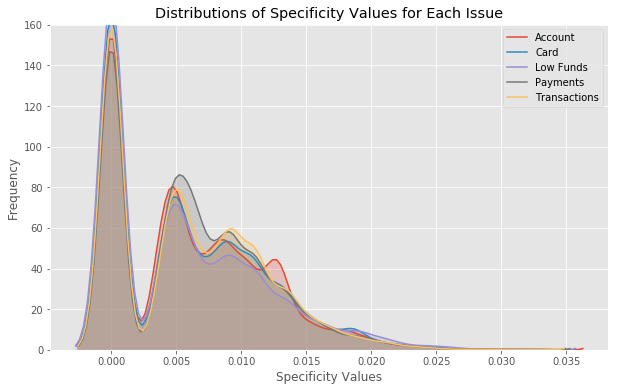

In [6]:
plt.figure(figsize=(10,6))
plt.title("Distributions of Specificity Values for Each Issue")
for issue in issues:
    sns.kdeplot(glob_df.loc[:,(issue,'tfidf')],shade=True,label=issue)
plt.ylabel('Frequency')
plt.xlabel('Specificity Values')
plt.show()

In [7]:
_ = np.random.choice(issues)

In [8]:
a = issue_text_samples[_].sample(1)
print(a.index[0],'\n')
print(a.values[0])

23 

I was taking money out of a Chase ATM Machine at a Chase Bank on   in  Ohio  , 2016 at roughly . During the transaction, the power failed at the ATM, debiting the amount, while not giving me my money ( Approximately {$120.00} ). I immediately called Chase, who told me I would receive my money " within 12 hours '' and an email confirming it would be sent, which I never received. 2 days later, without the money, I called again, and was repeatedly told " another 24 hours ''. 

This happened for 3 consecutive days, being told my " money was in the process of being transferred ''. Each time I was told to wait, in that " 24 hours '' my money would be refunded. 

Finally, after over a week of no information, I demanded to talk to a superior. I was told the investigation was completed, and that my money *should* have been issued, but for whatever reason, it was n't because of an " unspecified error '', but they would offer me " conditional credit '' that they would give me, but take out i

issueAliases = {
    'Account opening, closing, or management':'Account',
    'Deposits and withdrawals':'Transactions',
    'Making/receiving payments, sending money':'Payments',
    'Problems caused by my funds being low':'Low Funds',
    'Using a debit or ATM card':'Card'
}

As a human, I summarize what I read. This merchant processor was incorrectly handling payments. A false id theft label was involved. Situation seems pretty catastrophic. Lots of double crossing. 
Guess: account or payments 
Actual: payments.

#343: summary: Bank refused customer the right to deposit checks. Guess: Transactions. Actual: Transactions.

#436: summary: Brain enhancer. Redacted XXXX dollar amounts may have been helpful. xxxx bucks indicates a dollar amount. Brought should be bought, only way to fix this would inference from context. Guess: Payments, Second Guess: Transactions. Actual: Card

#495: Inappropriate, unfair, and greedy, emotional distress should send clear signals to product team. This should have negative sentiment. Customer mentioned 4.00 to name- not clear from words, but meaning indicates low funds. Issue was that customer received unfair overdraft fees. Guess: Low Funds. Actual: Account.

#76: Issue is that chase failed to give a withdrawn amount at an ATM which triggered some kind of ongoing bug. Guess: Transactions. Actual: Card. Error: Note that the issue involved a card. Which labels override the specificity of the other?

#81: A redacted third party caused a charge for a membership to debited from customer's PNC Account. Customer blaims PNC from re-applying the charge. Customer wants account closed. The customer did not initiate the payments. Guess: Account Second: Payments. Actual: Card. Error: The card was used for the payment, therefore it is considered a card issue.

#55: Customer can't transfer money out of wells fargo. Guess: Payments Second: Accounts Actual: Transactions. Error: Wire transfers are considered transactions.

#453: Unauthorized charges, followed by overdraft fees. Guess: Card, Second: Low Funds. Actual: Card. Feedback: Card seems to supercede other issues when in doubt.

#412: Problem with wells fargo handling funds being released from an insurance claims check. Guess: Transactions, Second: Account. Actual: Transactions

Transactions is intra. Payments is extra.

#16: Account was supposed to reject excessive charges. Has to do with low funds, but is an account management issue. Could also be considered a payments issue. Guess: Account, Second: low funds. Actual: Low funds. Error: Low funds is more specific?

#335: Wells fargo, overdraft. Guess: Low Funds, Actual: Low Funds.

### I would like to continue this process alongside the model. Perhaps I can test the hypothesis that my accuracy will be the same as the models.

Note: After 81 I looked up CFPB's definition of the categories and now have them handy. Unfortunately, they were updated.

Q: What is the diff btw payments and transactions?

Q: Who are the most complained about banks? per category?



Tech:
specking -> speaking
insuranceclaimscheck was a run on in 412, seperated words might allow for better word vectors.
Contractions handled might result in slightly better word vectors.
Interest is mispelled as interst. Overall spelling is good. 

In [9]:
print("Issue was: " + str(_))

Issue was: Card


### Let's take a look at a few of the most and least specific terms for each issue.

In [10]:
np.random.seed(47)

for issue in issues:
    print()
    print('\033[1m' + issue + ' Issues' + '\033[0m','\n')
    it = glob_df.loc[:,(issue,['tfidf','bow'])]
    it.columns = it.columns.get_level_values(1)
    it.columns = ["Frequency","Specificity"]
    unigrams = it.loc[[i for i in glob_df.index if len(i.split(' ')) == 1]].sort_values(by='Specificity',ascending=False)
    bigrams = it.loc[[i for i in glob_df.index if len(i.split(' ')) == 2]].sort_values(by='Specificity',ascending=False)
    it = it.sort_values(by=['Specificity'],ascending=False)
    print('One Word Phrases')
    print(unigrams.head(15))
    print()
    print('Two Word Phrases')
    print(bigrams.head(10))
    print()


Account Issues 

One Word Phrases
              Frequency  Specificity
Features                            
aadvantage         31.0     0.033437
citigold           66.0     0.031575
promo              24.0     0.031507
qualifying         24.0     0.031507
account          2014.0     0.030931
bank             1051.0     0.028594
points             99.0     0.028257
apy                15.0     0.027963
promotion         257.0     0.027824
thankyou           14.0     0.027443
00                580.0     0.026458
ira                25.0     0.025668
requirements      141.0     0.025274
told              414.0     0.025247
eligibility        10.0     0.024905

Two Word Phrases
                   Frequency  Specificity
Features                                 
citigold checking       32.0     0.033677
bonus miles             20.0     0.030132
promo code              19.0     0.029745
account promotion       19.0     0.029745
opened citigold         18.0     0.029338
promotion code          

### We'll need a good strategy for handling numeric values

The above examples illustrate that numeric values play a peculiar role in our extracted terms. If we transform these into ranges that capture the way they are being uses, these features might retain their specificity whilst becoming more prevalent within the issue as a whole. For example, 34 and 35 dollar fees are popular terms in 'Low Funds' that can be aggregated.

### Depending on the problem framing, we may want to remove certain proper nouns.

Names of banks in the CDFI data set that this project utilizes may not be realistic terms to consider, depending on the project's final framing of client + issue.

### How would a classifier do with predicting the topic based on these collections of terms?

A multinomial bayes classifier, based on a straight forward extension of Baye's theorem, was trained to predict the issue based on the term specificity scores for the words in each document.

The heatmap matrix below illustrates the classifier's ability to distinguish between various classes. 

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [12]:
example_set = b.reset_index(drop=True)[['clean_text','issue']].sort_index()

In [13]:
#assemble training examples and labels for unbalanced set
#Make the vocabulary correspond to the one learned from the topic globs.
examples_bow = bow_vectorize(example_set['clean_text'],(1.0))
examples_tfidf = tfidf_vectorize(examples_bow['m'],sublinear_tf=True)
labels = example_set['issue']
feature_names = pd.Series(examples_bow['cv'].get_feature_names())

### A binary Chi2 test offers a better measure of the term's correlation to the class than the class tfidf.

### Do this by assembling a matrix of features' chi2 value for each class as well as it's overall?

### Try assembling a symmetric matrix of the distance between each classes chi2 vectors. Blending classes ought to have smaller distance. Another way to quantify blend.

### Is localizing the confusion to particular terms useful? Which terms contribute to the total confusion between classes?

##### It will be interesting to compare the relative degree of confusion that different algorithms for classification will exhibit.

##### Possible end result: Compute IDF discounting on each term on the class level. Then use Log Term Frequency on the document level to apply IDFs to novel messages. Update the IDF based on new info every ____ hours.

# Note: make Sure this section can run independently of vestigial stuff.

In [14]:
n = 100

issue_top_chi2s = {}

for issue in issues:
    chi_vals = chi2(examples_tfidf['m'],labels == issue)
    #get index of n max chi_val words and compare to class
    print(issue)
    print(feature_names[(chi_vals[0].argsort()[-n:][::-1])].values)
    issue_top_chi2s[issue]=set(feature_names[(chi_vals[0].argsort()[-n:][::-1])].values)

Account
['bonus' 'promotion' 'requirements' 'citi' 'miles' 'overdraft' 'points'
 'offer' 'citigold' 'opened' 'met' 'opening' 'open' 'promotional'
 'overdraft fees' 'citibank' 'transaction' 'met requirements' 'atm'
 'transactions' 'closed' 'citigold checking' 'eligible'
 'citigold checking account' 'check' 'code' 'close' 'terms' 'funds' 'money'
 'account closed' 'overdraft fee' '90' '90 days' '00 bonus' 'charges'
 '35 00' 'close account' 'aadvantage' '35' 'application' 'opened account'
 'receive bonus' 'claim' 'opening account' 'promotion code' 'open account'
 'targeted' 'completed requirements' 'opened citigold' 'pending'
 'promotional offer' 'citigold account' 'account opening' 'confirmed'
 'accounts' 'conditions' 'day' 'account promotion' 'qualified'
 'credit report' 'promo' 'charged overdraft' 'open checking' 'meeting'
 'debit' 'fulfilled' 'fees' 'consecutive' 'bonus miles'
 'opened citigold checking' 'account opened' '00 overdraft' 'completing'
 'opened citigold checking account' '

In [15]:
print(issue_top_chi2s['Payments'].intersection(issue_top_chi2s['Transactions']),'\n',
      issue_top_chi2s['Account'].intersection(issue_top_chi2s['Transactions']),'\n',
      issue_top_chi2s['Account'].intersection(issue_top_chi2s['Payments'])
     )

{'fees', 'requirements', 'check', 'opened', 'deposit', 'bonus', 'cashed', 'promotion', 'miles'} 
 {'requirements', 'citibank', 'points', 'citi', 'application', 'bonus', 'promotion', 'code', 'offer', 'deposited', 'citigold', 'citigold checking account', 'open', 'funds available', 'miles', 'met', 'fees', 'opening', 'money', 'opened', 'citigold checking', 'eligible', 'withdrawal', 'available', 'cashed', 'funds', 'met requirements', 'check', 'promotional', 'credit report'} 
 {'fees', 'requirements', 'payment', 'overdraft fees', 'check', 'overdraft', 'atm', 'opened', 'bonus', 'cashed', 'promotion', 'miles'}


In [16]:
#Take a balanced sampling for an alternative training set and an unbalanced/stratified test set

class_balance = np.array([len(example_set[example_set['issue'] == issue]) for issue in issues])

es_copy = example_set.copy()
training_samples = []
test_samples = []
smallest_class_total = np.min(class_balance)
test_frac = 0.33
training_size = int(np.floor(smallest_class_total*(1-test_frac)))
min_test_size = smallest_class_total-training_size
test_sample_sizes = zip(issues,np.floor(class_balance*(min_test_size/smallest_class_total)))

for issue in issues:
    training_samples.append(es_copy[es_copy['issue'] == issue].sample(training_size,replace=False))
bal_training_set = pd.concat(training_samples)

es_copy = es_copy.drop(bal_training_set.index)
overlap_test=set(es_copy.index).intersection(set(bal_training_set.index))

for issue,test_size in test_sample_sizes:
    test_samples.append(es_copy[es_copy['issue'] == issue].sample(int(test_size),replace=False))
strat_test_set = pd.concat(test_samples)
    

In [17]:
#assemble training examples and labels for balanced set
#Make the vocabulary correspond to the one learned from the topic globs.

bal_training_bow = bow_conform(bal_training_set['clean_text'],feature_names)
bal_training_tfidf = tfidf_vectorize(bal_training_bow['m'],sublinear_tf=True)
bal_training_labels = bal_training_set['issue']

strat_test_bow = bow_conform(strat_test_set['clean_text'],feature_names)
strat_test_tfidf = tfidf_vectorize(strat_test_bow['m'],sublinear_tf=True)
strat_test_labels = strat_test_set['issue']

bal_X_train,bal_y_train = bal_training_tfidf['m'], bal_training_labels
strat_X_test, strat_y_test = strat_test_tfidf['m'], strat_test_labels

In [46]:
###Create target shuffled labels

In [47]:
bal_y_train_shuffled = bal_y_train.sample(frac=1)

In [48]:
#train a multinomial bayes classifier for both sets
bal_mnb_classifier = MultinomialNB()
bal_mnb_classifier.fit(X=bal_X_train,y=bal_y_train_shuffled)
print()

### Transactions and payments are the problem classes

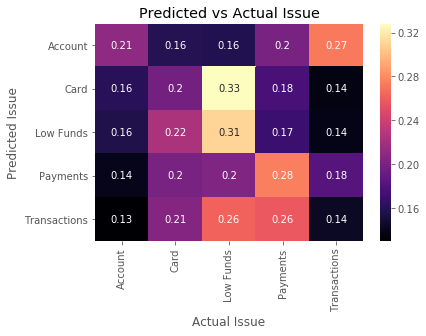

              precision    recall  f1-score   support

     Account       0.52      0.21      0.30      2095
        Card       0.11      0.20      0.14       527
   Low Funds       0.19      0.31      0.24       688
    Payments       0.12      0.28      0.17       472
Transactions       0.16      0.14      0.15      1130

 avg / total       0.31      0.21      0.23      4912

Num of training examples : [ 960.  960.  960.  960.  960.]


In [49]:
predictions = bal_mnb_classifier.predict(X=strat_X_test)
confusion = np.matrix(metrics.confusion_matrix(strat_y_test,predictions))
rel_confusion = confusion/confusion.sum(axis=1)
rc_df = pd.DataFrame(rel_confusion,index=issues,columns=issues)
heat = sns.heatmap(rc_df,cmap='magma',annot=True)
heat.set(xlabel = 'Actual Issue',ylabel = 'Predicted Issue',title= 'Predicted vs Actual Issue')
plt.show()
print(metrics.classification_report(strat_y_test,predictions))
print('Num of training examples :',bal_mnb_classifier.class_count_)

### Final Thoughts

As you can see above, some issues are easier to predict than others, and certain pairs seem to blend together. One possible explanation for this is that specific language is not consistently used. With our further feature engineering efforts, we'll try to find generalizable signifiers that are both widely distributed and unique to the issue.

Our model of term specificity presents an interesting issue in practice since we're classifying a single new document rather than a new large corpus of documents. In order to take the advantage of context, we will utilize the Inverse Document Frequency metric from our training data to weight the Term Frequency of the test data. Normally the Term Frequency and Inverse Document Frequency would be computed based on the same corpus. This should help weigh the features in such a way that topic-specific phrases are emphasized.

**Based on the above, we can see that a more developed classifier may be able to parse these categories in a majority of cases. However, if specific terms aren't prevalent enough in a message, our algorithm could ask for human help.** This means that a reliable metric of confidence will play an important role in getting this algorithm to avoid the mis-classifications evident in the heatmap above.

We will also want to explore non-supervised 'topic modeling' methods to help us deal with an initial stack of unsorted topics. In this phase, we could verify that the categories we use for classification are seperable to an algorithm as well as meaningful to a person.